In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import holidays
import requests
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [5]:
completed_df = pd.read_csv('../data/rawdata/nb.csv')
df = pd.read_csv('../data/rawdata/driver_locations_during_request.csv')

In [6]:
completed_df.columns

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time'],
      dtype='object')

In [7]:
df.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'created_at', 'updated_at'],
      dtype='object')

In [8]:
df = df.drop(['updated_at', 'created_at'], axis=1)

Feature Extraction

In [9]:
# Convert timestamp to datetime
completed_df['datetime'] = pd.to_datetime(completed_df['Trip Start Time'])

In [10]:
# Create hour of day
completed_df['hour'] = completed_df['datetime'].dt.hour

Get day of the week from datetime

In [11]:
from datetime import datetime

In [12]:
dt = datetime.now()
print('Datetime is:', dt)

print('day Name:', dt.strftime('%A'))

Datetime is: 2024-06-12 18:12:42.437889
day Name: Wednesday


In [13]:
# Create weekend vs. weekday feature
completed_df['is_weekend'] = completed_df['datetime'].dt.weekday >= 5

Add holiday Feature

In [14]:
# Add holiday feature
nigeria_holidays = holidays.CountryHoliday('NG')

In [15]:
# Create a function to check for holidays
def is_holiday(date):
    return date in nigeria_holidays

In [16]:
completed_df

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,2021-07-01 07:28:04,7.0,False
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,2021-07-01 06:38:04,6.0,False
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,2021-07-01 06:21:02,6.0,False
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,2021-07-01 07:16:07,7.0,False
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False
...,...,...,...,...,...,...,...,...
536015,1637696,"6.448218499999999,3.4772075","6.437787399999999,3.481670199999999",2021-12-30 20:35:06,2021-12-30 21:02:59,2021-12-30 20:35:06,20.0,False
536016,1637702,"6.442320899999999,3.4736868","6.436589333407897,3.5559738188407835",2021-12-30 20:48:13,2021-12-30 21:43:49,2021-12-30 20:48:13,20.0,False
536017,1637704,"6.4281982,3.492248","6.448088500000001,3.4775747",2021-12-30 20:51:45,2021-12-30 21:41:32,2021-12-30 20:51:45,20.0,False
536018,1637705,"6.5869296,3.3632966","6.637906899999999,3.3339515",2021-12-30 20:48:50,2021-12-30 21:08:28,2021-12-30 20:48:50,20.0,False


In [17]:
merged_df = pd.merge(completed_df, df, left_on='Trip ID', right_on='order_id')

In [18]:
merged_df = merged_df.drop(['id', 'order_id'], axis=1)

In [19]:
merged_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend,driver_id,driver_action,lat,lng
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243828,accepted,6.602207,3.270465
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243588,rejected,6.592097,3.287445
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243830,rejected,6.596133,3.281784
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243539,rejected,6.596142,3.280526
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,171653,rejected,6.609232,3.288800


In [20]:
merged_df['driver_action'].unique()

array(['accepted', 'rejected'], dtype=object)

In [21]:
merged_df['is_weekend'].unique()

array([False,  True])

In [22]:
merged_df['Driver Location'] = merged_df.apply(lambda row: f"{row['lat']}, {row['lng']}", axis=1)

In [23]:
merged_df['driver_clientdistance'] = merged_df.apply(lambda row: geodesic(
    (row['Driver Location']),
    (row['Trip Origin'])
).kilometers, axis=1)

In [24]:
merged_df = merged_df.drop(['lat', 'lng'], axis=1)

In [25]:
completed_df['Trip distance_km'] = completed_df.apply(lambda row: geodesic(
    (row['Trip Origin']),
    (row['Trip Destination'])
).kilometers, axis=1)

In [26]:
completed_df['Trip Start Time'] = pd.to_datetime(completed_df['Trip Start Time'])
completed_df['Trip End Time'] = pd.to_datetime(completed_df['Trip End Time'])
completed_df['duration_hours'] = completed_df.apply(lambda row: (row['Trip End Time'] - row['Trip Start Time']).total_seconds() / 3600, axis=1)

completed_df['speed_kmh'] = completed_df['Trip distance_km'] / completed_df['duration_hours']

In [27]:
completed_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend,Trip distance_km,duration_hours,speed_kmh
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,2021-07-01 07:28:04,7.0,False,16.123451,0.025833,624.133590
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,2021-07-01 06:38:04,6.0,False,1.884305,0.490000,3.845521
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,2021-07-01 06:21:02,6.0,False,13.822393,0.689167,20.056676
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,2021-07-01 07:16:07,7.0,False,1.511034,0.226389,6.674507
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,20.984319,0.060278,348.126952


In [29]:
# Day of the week feature
merged_df['day_of_week'] = merged_df['datetime'].dt.strftime('%A')

In [33]:
merged_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend,driver_id,driver_action,Driver Location,driver_clientdistance,day_of_week
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243828,accepted,"6.6022066, 3.2704649",0.694264,Thursday
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243588,rejected,"6.5920972, 3.2874447",1.551694,Thursday
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243830,rejected,"6.5961334, 3.2817841",0.786777,Thursday
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,243539,rejected,"6.5961416, 3.2805263",0.692054,Thursday
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9.0,False,171653,rejected,"6.6092317, 3.2887999",1.621848,Thursday


Rejections and accepted per day of the week

In [36]:
rejected_df = merged_df[merged_df['driver_action'] == 'rejected']

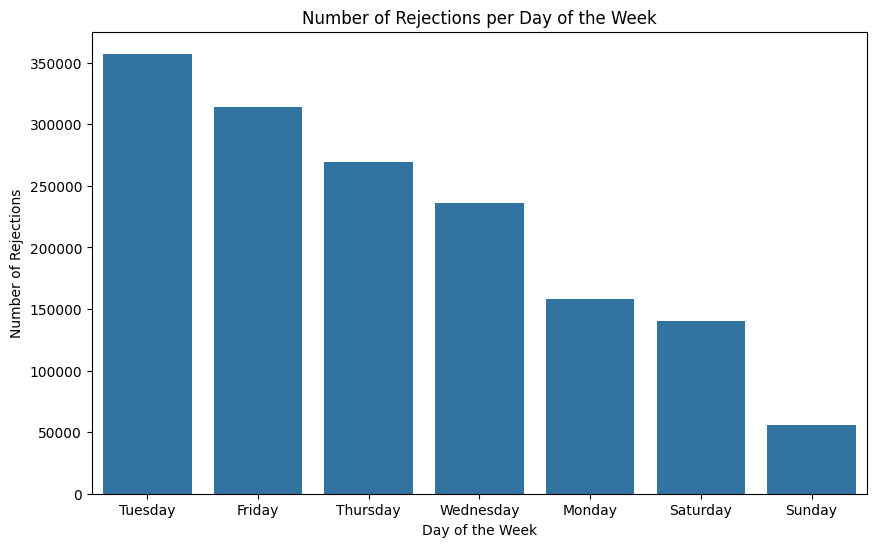

In [38]:
# Sort the filtered data by day_of_week
sorted_rejected_df = rejected_df.sort_values(by='day_of_week')

# Plotting the number of rejections per day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=sorted_rejected_df, order=sorted_rejected_df['day_of_week'].value_counts().index)
plt.title('Number of Rejections per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rejections')
plt.show()

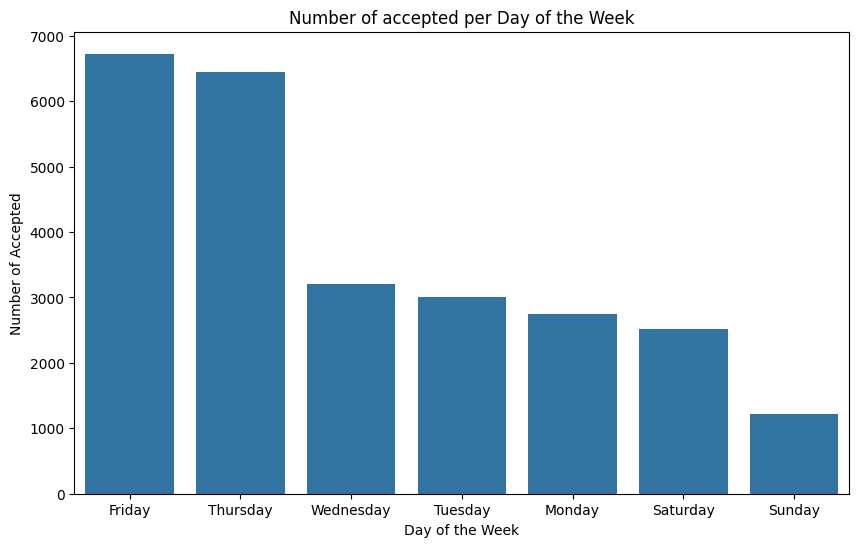

In [42]:
accepted_df = merged_df[merged_df['driver_action'] == 'accepted']

# Sort the filtered data by day_of_week
sorted_df = accepted_df.sort_values(by='day_of_week')

# Plotting the number of rejections per day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=sorted_df, order=sorted_df['day_of_week'].value_counts().index)
plt.title('Number of accepted per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accepted')
plt.show()

Top 10 drivers with most rejected and accepted

In [43]:
rejected_df['driver_id'].value_counts().head(10)

driver_id
245538    6937
243020    6447
242971    6237
243676    5844
243932    5787
171165    5710
243581    5176
244121    4939
244031    4902
243826    4883
Name: count, dtype: int64

In [44]:
accepted_df['driver_id'].value_counts().head(10)

driver_id
243296    69
245611    63
227856    60
244107    60
245649    59
243648    58
171149    58
243500    58
245587    57
243892    57
Name: count, dtype: int64

In [45]:
merged_df['driver_id'].nunique()

1213

Driver_client distance

In [55]:
# Detecting outliers using IQR
Q1 = merged_df['driver_clientdistance'].quantile(0.25)
Q3 = merged_df['driver_clientdistance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = merged_df[(merged_df['driver_clientdistance'] >= lower_bound) & (merged_df['driver_clientdistance'] <= upper_bound)]

In [56]:
distance_df = filtered_df.sort_values(by='driver_clientdistance', ascending=False)

In [57]:
top_distance_df = distance_df.head(10)

top_distance_df[['driver_clientdistance', 'driver_action']]


,driver_clientdistance,driver_action
867509,4.417888,rejected
914254,4.417857,rejected
914264,4.417857,rejected
787882,4.417852,rejected
787909,4.417852,rejected
744926,4.417827,rejected
848158,4.417789,rejected
848207,4.417789,rejected
848272,4.417789,rejected
848101,4.417789,rejected


In [58]:
bottom_distance_df = distance_df.tail(10)

bottom_distance_df[['driver_clientdistance', 'driver_action']]


,driver_clientdistance,driver_action
311314,0.0,accepted
167811,0.0,accepted
52946,0.0,accepted
1555016,0.0,accepted
637375,0.0,accepted
534633,0.0,accepted
1053064,0.0,accepted
415869,0.0,accepted
33739,0.0,accepted
585557,0.0,accepted


/home/grace-nyutu/Documents/Logistic_optimization/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


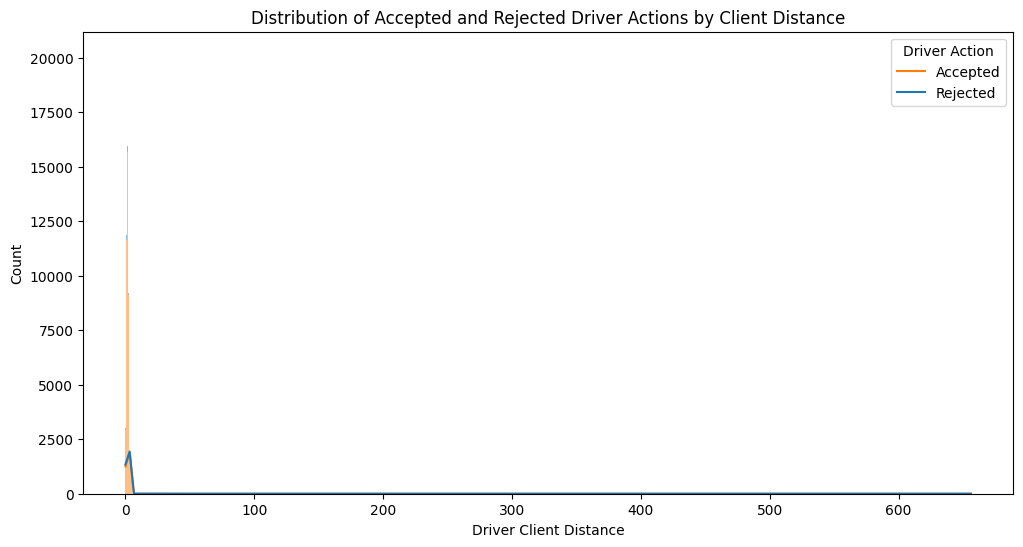

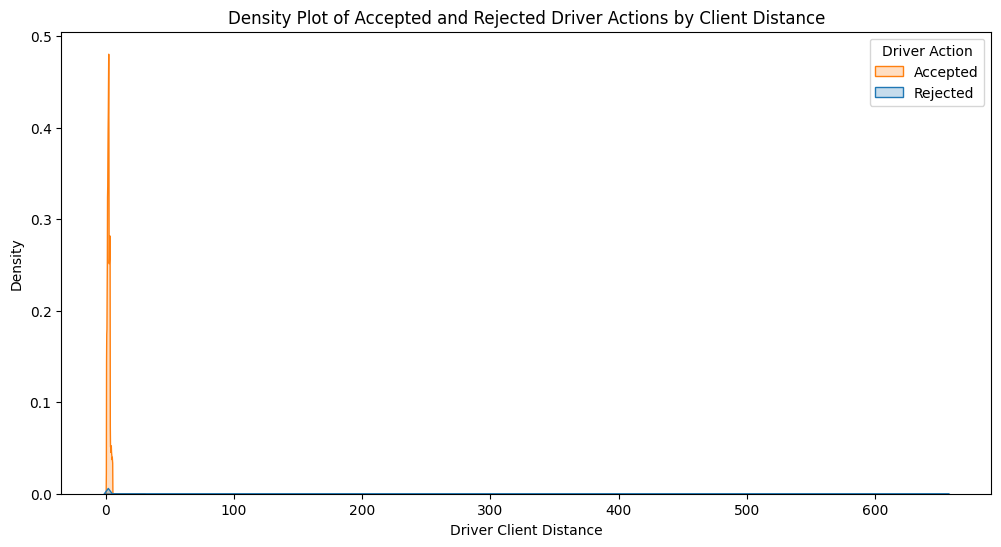

In [60]:
# Plotting
plt.figure(figsize=(12, 6))

# Histogram
sns.histplot(data=merged_df, x='driver_clientdistance', hue='driver_action', multiple='stack', kde=True)
plt.title('Distribution of Accepted and Rejected Driver Actions by Client Distance')
plt.xlabel('Driver Client Distance')
plt.ylabel('Count')
plt.legend(title='Driver Action', labels=['Accepted', 'Rejected'])

plt.show()

# Density Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(data=merged_df, x='driver_clientdistance', hue='driver_action', fill=True)
plt.title('Density Plot of Accepted and Rejected Driver Actions by Client Distance')
plt.xlabel('Driver Client Distance')
plt.ylabel('Density')
plt.legend(title='Driver Action', labels=['Accepted', 'Rejected'])

plt.show()


In [30]:
import os
from dotenv import load_dotenv

In [31]:
api_key = os.getenv("WEATHER_API_KEY")

In [32]:
# Function to get weather data 
def get_weather(lat, lng, datetime):
    API_KEY = 'WEATHER_API_KEY'
    url = f'https://api.weather.com/v1/geocode/{lat}/{lng}/observations/historical.json?apiKey={API_KEY}&startDate={datetime.strftime("%Y%m%d")}&endDate={datetime.strftime("%Y%m%d")}&units=e'
    response = requests.get(url)
    data = response.json()

In [39]:
# Save the DataFrame to a CSV file after EDA
output_csv_path = '../data/processeddata/completedrequests.csv'
completed_df.to_csv(output_csv_path, index=False)